<a href="https://colab.research.google.com/github/kai-neuhaus/OCT_reader/blob/master/OCT_reader_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is only for colab demo.

For local running code use OCT_reader.py on GitHub.

Run all cells the first time: Menu "Runtime - Run all".

Scroll to the last cell output.

The last cell can be modified and called repeatedly.

Additional modules to be installed should be 'xmltodict' and 'shutil'.

We install for colab also 'gdown' to download some example OCT file.

# Other aspects
## Unzipping the OCT file
The function unzip_OCTFile(```<fname>```) is in fact just extracting all files into a temporary folder.

## xmltodict
The xmltodict module is used to read the Header.xml into a dictionary.

Find the line in the unzip_OCTFile
```    
    handle_xml = xmltodict.parse(xmldoc)
    handle.update(handle_xml)
 ```
where the content of the ```Header.xml``` is converted into a dictionary ```handle_xml``` and added to the dictionary ```handle```.

Although the metadata parameters, such as __SizeX__ or __SizeZ__ etc., can be hardcoded for some one-off processing, the use of the dictionary makes it possible to read for different OCT files and different imaging data.

## get_OCTFileMetaData
This function shows how to get the metadata for each data file.

A data file can be `data\\VideoImage.data` or `data\\Spectral#.data`.
The `data\` part is currently an artifact if run on linux type systems and is a subfolder 'data'.

The placeholder '#' is any number for B-frame data and is an integer value 0,1,...,50,51,...,150,151,... and so on.

This function shows how to find the data file in the list of the 'DataFile' branch:
```
metadatas = handle['Ocity']['DataFiles']['DataFile'] # get list of all data files
# select the data file matching data_name
metadata = metadatas[np.argwhere([data_name in h['#text'] for h in handle['Ocity']['DataFiles']['DataFile']]).squeeze()]
```
which could be possibly written in an explicit loop like
```
# get list of all data files
for h in handle['Ocity']['DataFiles']['DataFile']:
  if data_name in h['#text']:
    metadata = h
    break
```

## get_OCTSpectralImage
This function demonstrates how to read a single data frame for a single B-frame and how to process to obtain a B-frame image.

For more sophisticated processing protocols it could make sense to construct a numpy 3D matrix and save it in an npy file or export it into a 'mat' file.

In [2]:
# import xmltodict and install if required
# Must run in separate cell such that install can finish
try:
  import xmltodict
except ModuleNotFoundError as e:
  !pip install xmltodict
  import xmltodict

In [3]:
# Import gdown and install if required
# Must run in separate cell such that install and download can finish
# https://kobkrit.com/how-to-directly-download-files-from-dropbox-or-google-drive-using-wget-in-terminal-or-in-google-573168195011    
try:
  import gdown
except ModuleNotFoundError as e:
  !pip install gdown 
  

In [4]:
print('xmltodict: ',xmltodict.__version__)
print('gdown: ',gdown.__version__)
import os
# download data if not exist
# must run in separate cell to finish befor next cell
if not os.path.exists('./test.oct'):
  !gdown --id '18xtWgvMdHw3OslDyyXZ6yMKDywhj_zdR' -O './test.oct'
  # import gdown

xmltodict:  0.12.0
gdown:  3.12.2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Reuse data in /var/folders/gs/_xxqy2nd4zb_73tw06rgnbdw0000gn/T/OCTData/test



dtype raw_signed_2 = <class 'numpy.int16'>
properties:
dict_keys(['filename', 'path', 'temp_oct_data_folder', 'Ocity', 'python_dtypes'])
odict_keys(['@version', 'DataFiles', 'Image', 'Acquisition', 'Processing', 'PolarizationProcessing', 'Instrument', 'MetaInfo', 'MarkerList'])
odict_keys(['IntensityAveraging', 'DopplerAveraging', 'SpeckleAveraging', 'Timestamp', 'ScanTime', 'ScanPause', 'RefractiveIndex', 'ReferenceIntensity', 'Saturation', 'Oversampling', 'ApodizationType', 'AcquisitionOrder'])
AfterCXL
1.370000
odict_keys(['FastAxis', 'SlowAxis'])
Speckle Averaging FastAxis:  1
odict_keys(['@Type', 'SizePixel', 'SizeReal', 'PixelSpacing', 'DataType', 'AxisOrder', 'CenterX', 'CenterY', 'Angle', 'Zoom', 'FreeformScanPatternIsActive', 'FreeformScanPatternCloseLoop', 'FreeformScanPatternInterpolation', 'MinPointDistance', 'MaxPointDistance'])


data file names:
data\VideoImage.data
data\Intensity.data
data\Spectral0.data
data\Spectral1.data
data\Chirp.data
data\ApodizationSpectrum.data


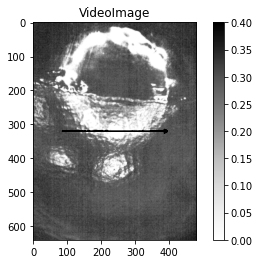

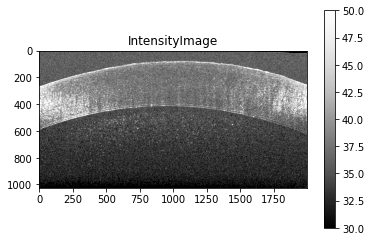

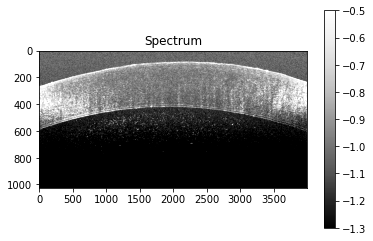

In [5]:
import numpy as np
from scipy.fftpack import fft,ifft
from scipy.interpolate import interp1d
import matplotlib.pyplot as pp
import tempfile
import zipfile
import warnings
from warnings import warn
# formatwarning_orig = warnings.formatwarning
# warnings.formatwarning = lambda message, category, filename, lineno, line=None: \
    # formatwarning_orig(message, category, filename='', lineno='', line='')


def unzip_OCTFile(filename):
    """
    Unzip the OCT file into a temp folder.
    """
    tempdir = tempfile.gettempdir()
    handle = dict()
    handle['filename'] = filename
    handle['path'] = os.path.join(tempdir, 'OCTData')

    temp_oct_data_folder = os.path.join(handle['path'],os.path.basename(filename).split('.oct')[0])
    handle['temp_oct_data_folder'] = temp_oct_data_folder
    if os.path.exists(temp_oct_data_folder) and os.path.exists(os.path.join(temp_oct_data_folder, 'Header.xml')):
        warn('Reuse data in {}\n'.format(temp_oct_data_folder))
    else:
        print('\nTry to extract {} into {}. Please wait.\n'.format(filename,temp_oct_data_folder))
        if not os.path.exists(handle['path']):
            os.mkdir(handle['path'])
        if not os.path.exists(temp_oct_data_folder):
            os.mkdir(temp_oct_data_folder)

        with zipfile.ZipFile(file=handle['filename']) as zf:
            zf.extractall(path=temp_oct_data_folder)

    # read Header.xml        
    with open(os.path.join(temp_oct_data_folder, 'Header.xml'),'rb') as fid:
        up_to_EOF = -1
        xmldoc = fid.read(up_to_EOF)
        
    # convert Header.xml to dict
    handle_xml = xmltodict.parse(xmldoc)
    handle.update(handle_xml)
    return handle

def get_OCTDataFileProps(handle, data_name=None, prop=None):
    """
    List some of the properties as in the Header.xml.
    """
    metadatas = handle['Ocity']['DataFiles']['DataFile']
    metadata = metadatas[np.argwhere([data_name in h['#text'] for h in handle['Ocity']['DataFiles']['DataFile']]).squeeze()]
    prop = metadata[prop]
    return prop

def get_OCTFileMetaData(handle, data_name):
    """
    The metadata for files are store in a list.
    The artifact 'data\\' stems from windows path separators and may need fixing.
    On mac and linux the file names will have 'data\\' as a name prefix.
    """
    # Check if data_name is available
    data_names_available = [d['#text'] for d in handle['Ocity']['DataFiles']['DataFile']]
    data_name = 'data\\'+data_name+'.data' # check this on windows
    assert data_name in data_names_available, 'Did not find {}.\nAvailable names are: {}'.format(data_name,data_names_available)

    metadatas = handle['Ocity']['DataFiles']['DataFile'] # get list of all data files
    # select the data file matching data_name
    metadata = metadatas[np.argwhere([data_name in h['#text'] for h in handle['Ocity']['DataFiles']['DataFile']]).squeeze()]
    return handle, metadata

def get_OCTVideoImage(handle):
    """
    Examples how to extract VideoImage data
    """
    handle, metadata = get_OCTFileMetaData(handle, 'VideoImage')
    # print(metadata) 
    data_filename = os.path.join(handle['temp_oct_data_folder'], metadata['#text'])
    img_type = metadata['@Type']
    dtype = handle['python_dtypes'][img_type][metadata['@BytesPerPixel']] # This is not consistent! unsigned and signed not distinguished!
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])
    data = np.fromfile(data_filename, dtype).reshape([sizeX,sizeZ])
    data = abs(data)/abs(data).max()
    return data

def get_OCTIntensityImage(handle):
    """
    Example how to extract Intensity data
    """
    handle, metadata = get_OCTFileMetaData(handle, data_name='Intensity')
    data_filename = os.path.join(handle['temp_oct_data_folder'], metadata['#text'])
    img_type = metadata['@Type'] # this is @Real
    dtype = handle['python_dtypes'][img_type][metadata['@BytesPerPixel']] # This is not consistent! unsigned and signed not distinguished!
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])
    data = (np.fromfile(data_filename, dtype=(dtype, [sizeX,sizeZ])))[0].T # there are two images. Take the first [0].
    return data

def get_OCTSpectralRawFrame(handle, idx = 0):
    """
    Demo read raw spectral data.
    Take note that we access all parameters using the dictionary from Header.xml.
    Although, this still looks a bit messy it should not require changes for different data.
    """
    # if the metadata are all the same for each Spectral.data then this can be called separately once
    handle, metadata = get_OCTFileMetaData(handle, data_name='Spectral'+str(idx))
    sign = handle['Ocity']['Instrument']['RawDataIsSigned'].replace('False','unsigned').replace('True','signed')
    apo_rng = range(int(metadata['@ApoRegionStart0']),int(metadata['@ApoRegionEnd0']))
    scan_rng = range(int(metadata['@ScanRegionStart0']),int(metadata['@ScanRegionEnd0']))
    bytesPP = metadata['@BytesPerPixel'] # probably 2
    raw_type = metadata['@Type'] # Raw
    data_filename = metadata['#text']
    data_file = os.path.join(handle['temp_oct_data_folder'], data_filename)
    dtype = handle['python_dtypes'][raw_type][sign][bytesPP]
    sizeX = int(metadata['@SizeX'])
    sizeZ = int(metadata['@SizeZ'])

    # select one [0] of two data frames
    raw_data = np.fromfile(data_file, dtype=(dtype, [sizeX,sizeZ]))[0]
    apo_data = raw_data[apo_rng]
    spec_data = raw_data[scan_rng]
    # return also apodization data
    return spec_data, apo_data

def get_OCTSpectralImage(handle):
    """
    Reconstruct the image from spectral data: remove DC; k-space-lin; ifft
    """
    spec, apo_data = get_OCTSpectralRawFrame(handle, idx = 0)

    binECnt = np.float(handle['Ocity']['Instrument']['BinaryToElectronCountScaling'])
    handle, metadata = get_OCTFileMetaData(handle, data_name='OffsetErrors')
    err_offset_fname = os.path.join(handle['temp_oct_data_folder'], metadata['#text'])
    err_offset = np.fromfile(err_offset_fname, dtype=handle['python_dtypes']['Real'][metadata['@BytesPerPixel']])

    handle, metadata = get_OCTFileMetaData(handle, data_name='ApodizationSpectrum')
    apodization_fname = os.path.join(handle['temp_oct_data_folder'], metadata['#text'])
    apodization_data = np.fromfile(apodization_fname, dtype=handle['python_dtypes']['Real'][metadata['@BytesPerPixel']])
    # same length after ifft

    handle, metadata = get_OCTFileMetaData(handle, data_name='Chirp')
    chirp_fname = os.path.join(handle['temp_oct_data_folder'], metadata['#text'])
    chirp_data = np.fromfile(chirp_fname, dtype=handle['python_dtypes']['Real'][metadata['@BytesPerPixel']])

    bframe = spec - np.mean(apo_data,axis=0) # Subtract DC using inline apo_data

    ip_fun = interp1d(x=chirp_data, y=bframe) # create interpolation on chirp_data
    num_samples = bframe.shape[1] # SizeZ
    bframe = ip_fun(np.arange(num_samples)) # k-space linearize

    return bframe

def demo_printing_parameters(handle):
    """
    This functions demonstrates how to access the xml paratemeters from the dictionary.
    The parameters are read in the unzip_OCTFile function.

    See this code snipped to read the Header.xml data:

    with open(os.path.join(temp_oct_data_folder, 'Header.xml'),'rb') as fid:
    up_to_EOF = -1
    xmldoc = fid.read(up_to_EOF)

    handle_xml = xmltodict.parse(xmldoc)
    handle.update(handle_xml)

    :param handle:
    :return:
    """
    # example to list properties
    print('properties:')
    print(handle.keys())  # list all keys in handle
    print(handle['Ocity'].keys())  # list all keys in Ocity. This is from Header.xml
    print(handle['Ocity']['Acquisition'].keys())  # list all keys in Acquisition
    print(handle['Ocity']['MetaInfo']['Comment'])  # get comment value from MetaInfo

    print(handle['Ocity']['Acquisition']['RefractiveIndex'])
    print(handle['Ocity']['Acquisition']['SpeckleAveraging'].keys())
    fastaxis = handle['Ocity']['Acquisition']['SpeckleAveraging']['FastAxis']
    print('Speckle Averaging FastAxis: ', fastaxis)
    print(handle['Ocity']['Image'].keys())

    # example list all data files
    print('\n\ndata file names:')
    [print(h['#text']) for h in handle['Ocity']['DataFiles']['DataFile']]

    print(get_OCTDataFileProps(handle, data_name='VideoImage', prop='@Type'))  # print type of video image
    print(get_OCTDataFileProps(handle, data_name='Intensity', prop='@Type'))


# Example usage
handle = unzip_OCTFile('./test.oct');

# Create a python_types dictionary for required data types
# I.e. the Thorlabs concept can mean a "Raw - signed - 2 bytes" --> np.int16
python_dtypes = {'Colored': {'4': np.int32, '2': np.int16},
                 'Real': {'4': np.float32},
                 'Raw': {'signed': {'1': np.int8, '2': np.int16},
                         'unsigned': {'1': np.uint8, '2': np.uint16}}}
print('dtype raw_signed_2 =',python_dtypes['Raw']['signed']['2']) # demo to get Raw_signed_2 --> np.int16
handle.update({'python_dtypes': python_dtypes})

# print some parameters from the xml file
demo_printing_parameters(handle)

# get and plot VideoImage
data = get_OCTVideoImage(handle)
title = 'VideoImage'
fig,ax = pp.subplots(1,num=title)
ax.set_title(title)
im = ax.imshow(data,cmap='Greys',vmin=0.0,vmax=0.4)
pp.colorbar(mappable=im)

# get and plot IntensityImage
data = get_OCTIntensityImage(handle)
title = 'IntensityImage'
fig,ax = pp.subplots(1,num=title)
ax.set_title(title)
im = ax.imshow(data,cmap='Greys_r',vmin=30,vmax=50)
pp.colorbar(mappable=im)

# get and processed spectral data, and plot the image
data = get_OCTSpectralImage(handle)
title = 'Spectrum'
fig, ax = pp.subplots(1,num=title)
im = ax.imshow(np.log10(abs(ifft(data)))[:,0:1024].T,
               vmin=-1.3,
               vmax=-0.5, 
               cmap='Greys_r',
               aspect=2,
               interpolation='antialiased')
ax.set_title(title)
pp.colorbar(mappable=im)

pp.show()
